In [1]:
# Fixing automatic autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os

import matplotlib.pyplot as plt
import numpy as np

from torchvision.transforms import PILToTensor
from utils import (
    read_data, 
    get_metadata,
    get_cell_annotations_in_tissue_coordinates,
    crop_and_upscale_tissue
)

tensor_transformation = PILToTensor()

In [3]:
folder_path = "ocelot_data/"
metadata = get_metadata(folder_path)
train_data, val_data, test_data = read_data(folder_path)

Skipped file number 217 as the .csv was empty.
Skipped file number 042 as the .csv was empty.
Skipped file number 053 as the .csv was empty.
Skipped file number 008 as the .csv was empty.
Skipped file number 392 as the .csv was empty.
Skipped file number 570 as the .csv was empty.
Skipped file number 558 as the .csv was empty.


In [4]:
for key, sample in metadata["sample_pairs"].items(): 
  if sample["cell"]["resized_mpp_x"] != sample["cell"]["resized_mpp_y"]: 
    print("diff")
  if sample["tissue"]["resized_mpp_x"] != sample["tissue"]["resized_mpp_y"]: 
    print("diff")
  if sample["mpp_x"] != sample["mpp_y"]: 
    print("diff")


In [6]:
# Splitting the data dictionary into tensors for future processing
tissue_tensors = []
cell_tensors = []

for file_name in sorted(list(train_data.keys())):
    tissue_tensors.append(train_data[file_name]["tissue_annotated"])
    cell_tensors.append(train_data[file_name]["cell_annotated"])

tissue_tensors = torch.stack(tissue_tensors)

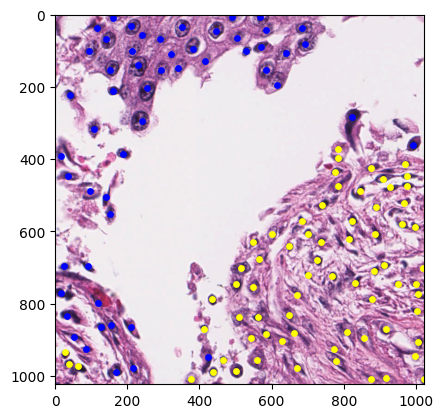

In [7]:
img_id = "288"
plt.imshow(np.transpose(train_data[img_id]["cell_image"], (1, 2, 0)), cmap="grey")
for cor in train_data[img_id]["cell_annotated"]:
    x, y = cor[0], cor[1]
    color = "yellow" if cor[2] == 1 else "blue"
    plt.scatter(x, y, color=color, s=15)

In [8]:
# Trying out the functionality with id 288
img_id = "288"
cell_annotations = train_data[img_id]["cell_annotated"]
cell_coords, cell_labels = cell_annotations[:, :2], cell_annotations[:, 2]
tissue_annotations = get_cell_annotations_in_tissue_coordinates(
    train_data[img_id], image_size=1024
)
tissue_coords, tissue_labels = tissue_annotations[:, :2], tissue_annotations[:, 2]
tissue_image = train_data[img_id]["tissue_image"]
cell_image = train_data[img_id]["cell_image"]
tissue_annotated_image = train_data[img_id]["tissue_annotated"]

rgb_image = np.zeros((1024, 1024, 3), dtype=np.uint8)
rgb_image[tissue_annotated_image[0] == 2, 1] = 255
rgb_image = np.transpose(rgb_image, (2, 0, 1))

alpha = 0.2
green_blend = (alpha * rgb_image + (1 - alpha) * tissue_image.numpy()).astype(np.uint8)

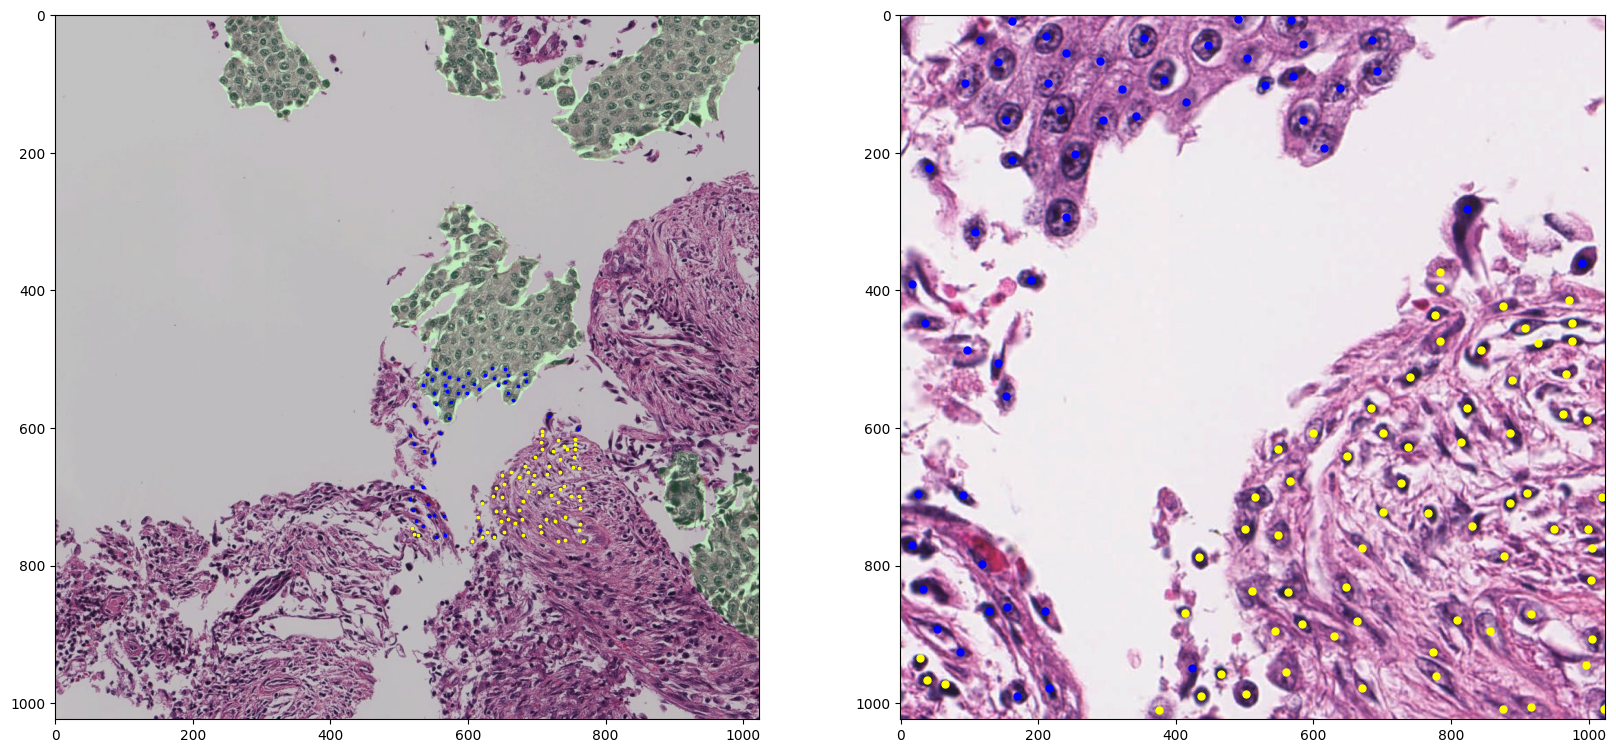

In [9]:
plt.figure(figsize=(20, 10)) 

# Plotting the translated points
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(green_blend, (1, 2, 0)), cmap="grey")
# plt.imshow(np.transpose(tissue_annotated_image, (1, 2, 0)), cmap="grey", alpha=0.8)
for i in range(len(tissue_coords)): 
    x, y = tissue_coords[i]
    color = "yellow" if tissue_labels[i] == 1 else "blue"
    plt.scatter(x, y, color=color, s=3)

# Plotting the actual points 
plt.subplot(1, 2, 2)
plt.imshow(np.transpose(cell_image, (1, 2, 0)), cmap="gray")
for i in range(len(cell_coords)): 
    x, y = cell_coords[i]
    color = "yellow" if cell_labels[i] == 1 else "blue"
    plt.scatter(x, y, color=color, s=25)

In [10]:
num_TC = 0
num_TC_CA = 0

for sample_id, sample in train_data.items(): 
  tissue_annotations = get_cell_annotations_in_tissue_coordinates(sample, image_size=1024)

  sample_num_TC = (tissue_annotations[:, 2] == 2).sum()
  num_TC += sample_num_TC

  tissue_annotated_image = sample["tissue_annotated"].squeeze()
  sample_num_TC_CA = 0
  for (x, y, label) in tissue_annotations: 
    if tissue_annotated_image[y, x] == 2 and label == 2: 
      sample_num_TC_CA += 1
  num_TC_CA += sample_num_TC_CA

print(num_TC)
print(num_TC_CA)
print(num_TC_CA / num_TC.item())

tensor(42505)
39198
0.9221973885425244


In [11]:
cell_coordinates = train_data["288"]["cell_annotated"]
tissue = train_data["288"]["tissue_annotated"]
# cell_coordinates = cell_tensors[287]
# tissue = tissue_tensors[287]
cell_annotation = cell_coordinates[:, 2]
cell_coordinates = cell_coordinates[:, :2]

In [12]:
print(cell_coordinates[0,:])
print(cell_annotation[0])

tensor([741, 526])
tensor(1)


## Calculate tumor cells in cancer area

In [13]:
csv_directory = "ocelot_data/annotations/test/cell"
csv_files = sorted([f for f in os.listdir(csv_directory) if f.endswith(".csv")])
print(csv_files[-1])
print(len(csv_files))
print(537 + 126)

667.csv
126
663


## Crop and scale tissue images with annotations

/Users/jarl/school/fall23/specialization_project/histopathology_segmentation/utils.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(resized_tensor, dtype=torch.uint8)


(-0.5, 1023.5, 1023.5, -0.5)

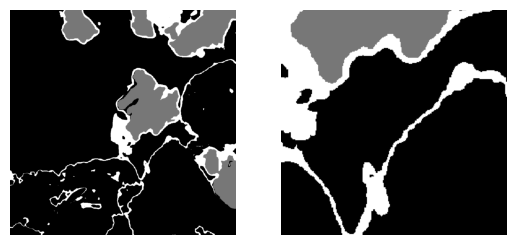

In [14]:
data_object = train_data["288"]
image_size = 1024

offset_tensor = torch.tensor([data_object["x_offset"], data_object["y_offset"]]) * image_size
scaling_value = data_object["cell_mpp"] / data_object["tissue_mpp"]
tissue_tensor = data_object["tissue_annotated"]

tissue_tensor = crop_and_upscale_tissue(tissue_tensor, offset_tensor, scaling_value)

data_object["tissue_annotated"][data_object["tissue_annotated"] == 2] = 120
tissue_tensor[tissue_tensor == 2] = 120

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(data_object["tissue_annotated"], (1, 2, 0)), cmap="grey")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(np.transpose(tissue_tensor, (1, 2, 0)), cmap="grey")
plt.axis("off")



In [15]:

cell_channels_with_tissue_annotations = []

for id in sorted(list(train_data.keys())):
    data_object = train_data[id]
    offset_tensor = torch.tensor([data_object["x_offset"], data_object["y_offset"]]) * image_size
    scaling_value = data_object["cell_mpp"] / data_object["tissue_mpp"]
    tissue_tensor = data_object["tissue_annotated"]
    cell_tensor = data_object["cell_image"]

    cropped_scaled = crop_and_upscale_tissue(tissue_tensor, offset_tensor, scaling_value)
    cell_tensor_tissue_annotation = torch.cat([cell_tensor, cropped_scaled], 0)
    
    cell_channels_with_tissue_annotations.append(cell_tensor_tissue_annotation)

tissue_crops_scaled_tensor = torch.stack(cell_channels_with_tissue_annotations)

(-0.5, 1023.5, 1023.5, -0.5)

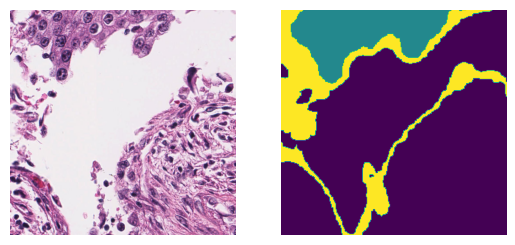

In [16]:
idx = 283
# print(type(tissue_crops_scaled_tensor))
plt.subplot(1, 2, 1)
plt.imshow(tissue_crops_scaled_tensor[idx, :3, :, :].permute((1, 2, 0)))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(tissue_crops_scaled_tensor[idx, 3, :, :])
plt.axis("off")